# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

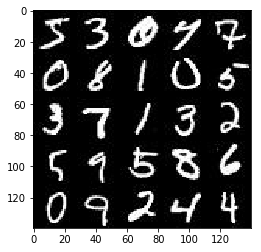

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

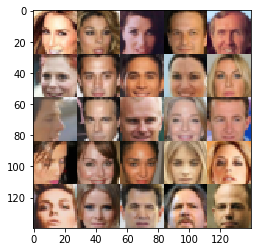

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32)

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.8)
        # 14x14x64 now
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', 
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.8)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', 
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.8)
        # 4x4x256 now
        
        flat = tf.reshape(x3, [-1, 4*4*256])
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, [-1, 4, 4, 512])
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.8)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid', 
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.8)
        # 7x7x256 now
        # out_height = in_height * stride + filter_height - 1
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', 
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.8)
        # 14x14x128 now
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same', 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xout_channel_dim now
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                   labels=tf.ones_like(d_model_fake)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, len(data_image_mode))
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    steps = 0
    
    session_cfg = tf.ConfigProto()
    session_cfg.gpu_options.allow_growth = True
    with tf.Session(config=session_cfg) as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2
                steps += 1 
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = sess.run(d_loss, feed_dict={input_real: batch_images, input_z: batch_z})
                    train_loss_g = sess.run(g_loss, feed_dict={input_z: batch_z})
                    
                    print('Epoch: {}/{}'.format(epoch_i+1, epoch_count),
                          'Discriminator Loss: {:.4f}'.format(train_loss_d),
                          'Generator Loss: {:.4f}'.format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, len(batch_images), input_z, len(data_image_mode), data_image_mode)
                
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch: 1/2 Discriminator Loss: 0.7453 Generator Loss: 14.2254
Epoch: 1/2 Discriminator Loss: 0.5032 Generator Loss: 5.6322
Epoch: 1/2 Discriminator Loss: 0.9533 Generator Loss: 10.2553
Epoch: 1/2 Discriminator Loss: 3.4145 Generator Loss: 0.2469
Epoch: 1/2 Discriminator Loss: 0.7448 Generator Loss: 2.9971
Epoch: 1/2 Discriminator Loss: 0.6275 Generator Loss: 2.5168
Epoch: 1/2 Discriminator Loss: 0.6640 Generator Loss: 1.9469
Epoch: 1/2 Discriminator Loss: 0.6673 Generator Loss: 2.2058
Epoch: 1/2 Discriminator Loss: 0.9319 Generator Loss: 3.7144
Epoch: 1/2 Discriminator Loss: 0.5229 Generator Loss: 3.6133


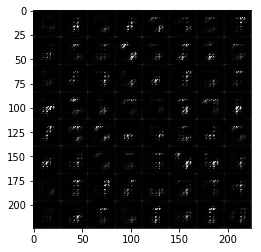

Epoch: 1/2 Discriminator Loss: 0.9722 Generator Loss: 1.1527
Epoch: 1/2 Discriminator Loss: 0.8888 Generator Loss: 3.1866
Epoch: 1/2 Discriminator Loss: 0.8578 Generator Loss: 2.5909
Epoch: 1/2 Discriminator Loss: 1.2841 Generator Loss: 0.8808
Epoch: 1/2 Discriminator Loss: 0.7905 Generator Loss: 2.1811
Epoch: 1/2 Discriminator Loss: 0.8501 Generator Loss: 1.7575
Epoch: 1/2 Discriminator Loss: 1.0150 Generator Loss: 1.5051
Epoch: 1/2 Discriminator Loss: 0.6930 Generator Loss: 2.3726
Epoch: 1/2 Discriminator Loss: 1.1017 Generator Loss: 1.1295
Epoch: 1/2 Discriminator Loss: 0.7574 Generator Loss: 2.0867


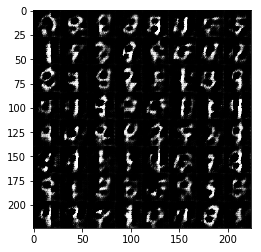

Epoch: 1/2 Discriminator Loss: 0.8668 Generator Loss: 1.9465
Epoch: 1/2 Discriminator Loss: 1.0968 Generator Loss: 1.4134
Epoch: 1/2 Discriminator Loss: 1.3532 Generator Loss: 0.7811
Epoch: 1/2 Discriminator Loss: 0.9383 Generator Loss: 1.4067
Epoch: 1/2 Discriminator Loss: 1.7302 Generator Loss: 3.0382
Epoch: 1/2 Discriminator Loss: 1.2488 Generator Loss: 0.8307
Epoch: 1/2 Discriminator Loss: 0.9658 Generator Loss: 1.5516
Epoch: 1/2 Discriminator Loss: 1.4518 Generator Loss: 0.8774
Epoch: 1/2 Discriminator Loss: 1.1413 Generator Loss: 1.2093
Epoch: 1/2 Discriminator Loss: 0.8371 Generator Loss: 1.7290


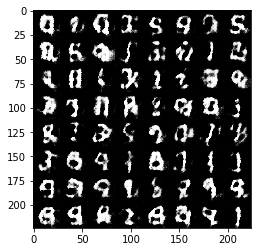

Epoch: 1/2 Discriminator Loss: 0.8710 Generator Loss: 1.7199
Epoch: 1/2 Discriminator Loss: 1.0512 Generator Loss: 0.9536
Epoch: 1/2 Discriminator Loss: 1.2420 Generator Loss: 1.0132
Epoch: 1/2 Discriminator Loss: 0.8280 Generator Loss: 1.4867
Epoch: 1/2 Discriminator Loss: 1.0621 Generator Loss: 1.6980
Epoch: 1/2 Discriminator Loss: 0.7854 Generator Loss: 1.6482
Epoch: 1/2 Discriminator Loss: 1.0571 Generator Loss: 1.3796
Epoch: 1/2 Discriminator Loss: 0.9787 Generator Loss: 1.0836
Epoch: 1/2 Discriminator Loss: 1.5315 Generator Loss: 0.6701
Epoch: 1/2 Discriminator Loss: 1.2765 Generator Loss: 0.7954


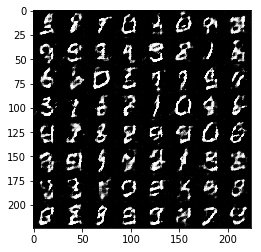

Epoch: 1/2 Discriminator Loss: 1.3136 Generator Loss: 0.8284
Epoch: 1/2 Discriminator Loss: 0.9551 Generator Loss: 1.2968
Epoch: 1/2 Discriminator Loss: 0.9756 Generator Loss: 1.3822
Epoch: 1/2 Discriminator Loss: 0.8968 Generator Loss: 1.8033
Epoch: 1/2 Discriminator Loss: 1.1074 Generator Loss: 1.3738
Epoch: 1/2 Discriminator Loss: 1.3330 Generator Loss: 0.6287
Epoch: 1/2 Discriminator Loss: 1.1527 Generator Loss: 0.9593
Epoch: 1/2 Discriminator Loss: 1.0050 Generator Loss: 1.6998
Epoch: 1/2 Discriminator Loss: 1.2468 Generator Loss: 1.6940
Epoch: 1/2 Discriminator Loss: 0.8026 Generator Loss: 1.4745


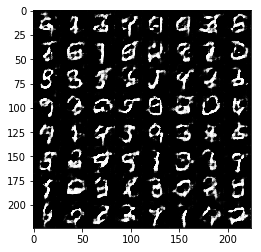

Epoch: 1/2 Discriminator Loss: 1.1286 Generator Loss: 1.6035
Epoch: 1/2 Discriminator Loss: 1.1175 Generator Loss: 1.5312
Epoch: 1/2 Discriminator Loss: 1.0382 Generator Loss: 1.8635
Epoch: 1/2 Discriminator Loss: 1.2302 Generator Loss: 1.0263
Epoch: 1/2 Discriminator Loss: 1.1095 Generator Loss: 1.8355
Epoch: 1/2 Discriminator Loss: 1.4204 Generator Loss: 2.2907
Epoch: 1/2 Discriminator Loss: 1.2139 Generator Loss: 0.8413
Epoch: 1/2 Discriminator Loss: 1.3622 Generator Loss: 0.7595
Epoch: 1/2 Discriminator Loss: 1.1244 Generator Loss: 1.3494
Epoch: 1/2 Discriminator Loss: 1.6079 Generator Loss: 0.4834


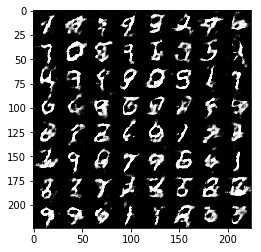

Epoch: 1/2 Discriminator Loss: 1.0576 Generator Loss: 1.3916
Epoch: 1/2 Discriminator Loss: 1.1529 Generator Loss: 1.5542
Epoch: 1/2 Discriminator Loss: 1.1237 Generator Loss: 1.3823
Epoch: 1/2 Discriminator Loss: 0.9789 Generator Loss: 1.1073
Epoch: 1/2 Discriminator Loss: 1.1004 Generator Loss: 1.0838
Epoch: 1/2 Discriminator Loss: 1.1789 Generator Loss: 1.0110
Epoch: 1/2 Discriminator Loss: 1.1801 Generator Loss: 1.3542
Epoch: 1/2 Discriminator Loss: 1.3556 Generator Loss: 0.8024
Epoch: 1/2 Discriminator Loss: 0.9044 Generator Loss: 1.4130
Epoch: 1/2 Discriminator Loss: 1.1039 Generator Loss: 1.9037


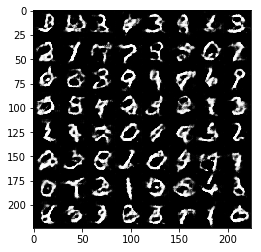

Epoch: 1/2 Discriminator Loss: 1.1649 Generator Loss: 1.4783
Epoch: 1/2 Discriminator Loss: 1.0278 Generator Loss: 1.3196
Epoch: 1/2 Discriminator Loss: 1.0806 Generator Loss: 1.4841
Epoch: 1/2 Discriminator Loss: 1.0887 Generator Loss: 1.8846
Epoch: 1/2 Discriminator Loss: 0.9438 Generator Loss: 1.4971
Epoch: 1/2 Discriminator Loss: 1.1772 Generator Loss: 0.8984
Epoch: 1/2 Discriminator Loss: 1.1217 Generator Loss: 1.2771
Epoch: 1/2 Discriminator Loss: 1.1115 Generator Loss: 0.9960
Epoch: 1/2 Discriminator Loss: 1.2029 Generator Loss: 0.8759
Epoch: 1/2 Discriminator Loss: 1.1449 Generator Loss: 0.9052


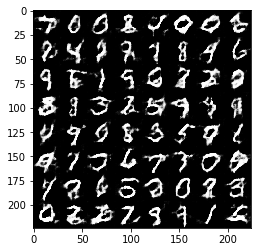

Epoch: 1/2 Discriminator Loss: 1.1514 Generator Loss: 1.2081
Epoch: 1/2 Discriminator Loss: 1.2689 Generator Loss: 0.9622
Epoch: 1/2 Discriminator Loss: 1.1129 Generator Loss: 1.5933
Epoch: 1/2 Discriminator Loss: 0.8840 Generator Loss: 1.3128
Epoch: 1/2 Discriminator Loss: 0.9695 Generator Loss: 1.5394
Epoch: 1/2 Discriminator Loss: 1.2350 Generator Loss: 0.9676
Epoch: 1/2 Discriminator Loss: 1.2308 Generator Loss: 1.0465
Epoch: 1/2 Discriminator Loss: 1.1020 Generator Loss: 0.9781
Epoch: 1/2 Discriminator Loss: 0.9686 Generator Loss: 1.8555
Epoch: 1/2 Discriminator Loss: 1.0902 Generator Loss: 0.9549


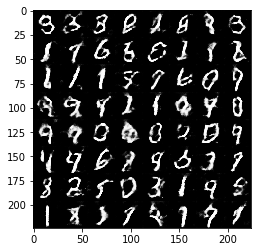

Epoch: 1/2 Discriminator Loss: 0.9551 Generator Loss: 1.3721
Epoch: 1/2 Discriminator Loss: 1.1515 Generator Loss: 1.0559
Epoch: 1/2 Discriminator Loss: 1.1839 Generator Loss: 1.1559
Epoch: 2/2 Discriminator Loss: 1.1897 Generator Loss: 0.8847
Epoch: 2/2 Discriminator Loss: 0.9925 Generator Loss: 1.2526
Epoch: 2/2 Discriminator Loss: 1.0945 Generator Loss: 1.0228
Epoch: 2/2 Discriminator Loss: 1.0964 Generator Loss: 1.0715
Epoch: 2/2 Discriminator Loss: 1.2812 Generator Loss: 0.8442
Epoch: 2/2 Discriminator Loss: 1.0824 Generator Loss: 1.8213
Epoch: 2/2 Discriminator Loss: 1.0850 Generator Loss: 1.3799


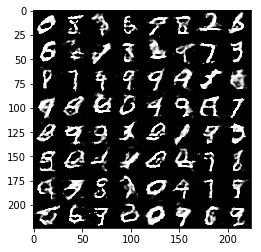

Epoch: 2/2 Discriminator Loss: 0.9618 Generator Loss: 1.5358
Epoch: 2/2 Discriminator Loss: 0.9987 Generator Loss: 0.9347
Epoch: 2/2 Discriminator Loss: 1.1616 Generator Loss: 0.7371
Epoch: 2/2 Discriminator Loss: 1.3411 Generator Loss: 0.8030
Epoch: 2/2 Discriminator Loss: 1.1058 Generator Loss: 1.3578
Epoch: 2/2 Discriminator Loss: 0.9175 Generator Loss: 1.5907
Epoch: 2/2 Discriminator Loss: 1.2341 Generator Loss: 1.0491
Epoch: 2/2 Discriminator Loss: 1.0722 Generator Loss: 0.8249
Epoch: 2/2 Discriminator Loss: 1.2313 Generator Loss: 1.9894
Epoch: 2/2 Discriminator Loss: 1.1628 Generator Loss: 0.7867


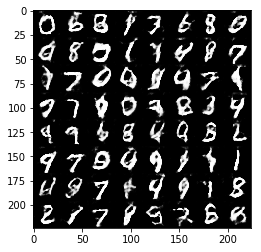

Epoch: 2/2 Discriminator Loss: 1.1399 Generator Loss: 0.7212
Epoch: 2/2 Discriminator Loss: 1.0675 Generator Loss: 1.1695
Epoch: 2/2 Discriminator Loss: 0.8083 Generator Loss: 1.5349
Epoch: 2/2 Discriminator Loss: 0.9474 Generator Loss: 1.5508
Epoch: 2/2 Discriminator Loss: 1.1638 Generator Loss: 0.9866
Epoch: 2/2 Discriminator Loss: 1.0290 Generator Loss: 1.1265
Epoch: 2/2 Discriminator Loss: 1.0893 Generator Loss: 0.8907
Epoch: 2/2 Discriminator Loss: 1.4205 Generator Loss: 0.7650
Epoch: 2/2 Discriminator Loss: 1.2506 Generator Loss: 0.6667
Epoch: 2/2 Discriminator Loss: 0.9662 Generator Loss: 1.0197


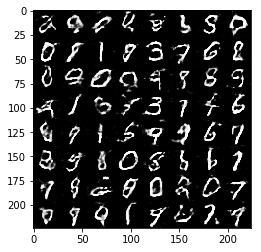

Epoch: 2/2 Discriminator Loss: 1.0140 Generator Loss: 1.3210
Epoch: 2/2 Discriminator Loss: 1.2873 Generator Loss: 2.0088
Epoch: 2/2 Discriminator Loss: 1.0321 Generator Loss: 1.0759
Epoch: 2/2 Discriminator Loss: 1.0322 Generator Loss: 1.3741
Epoch: 2/2 Discriminator Loss: 1.1365 Generator Loss: 2.0715
Epoch: 2/2 Discriminator Loss: 0.9957 Generator Loss: 1.6054
Epoch: 2/2 Discriminator Loss: 1.1717 Generator Loss: 0.8386
Epoch: 2/2 Discriminator Loss: 1.1619 Generator Loss: 0.9078
Epoch: 2/2 Discriminator Loss: 1.0414 Generator Loss: 2.1074
Epoch: 2/2 Discriminator Loss: 1.2801 Generator Loss: 2.6522


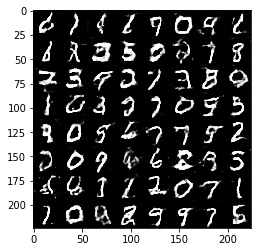

Epoch: 2/2 Discriminator Loss: 1.1520 Generator Loss: 1.1240
Epoch: 2/2 Discriminator Loss: 0.9445 Generator Loss: 1.6239
Epoch: 2/2 Discriminator Loss: 0.9148 Generator Loss: 1.1755
Epoch: 2/2 Discriminator Loss: 0.9711 Generator Loss: 1.6882
Epoch: 2/2 Discriminator Loss: 0.9408 Generator Loss: 1.3446
Epoch: 2/2 Discriminator Loss: 1.2171 Generator Loss: 0.8645
Epoch: 2/2 Discriminator Loss: 1.0508 Generator Loss: 1.1560
Epoch: 2/2 Discriminator Loss: 0.8438 Generator Loss: 1.6772
Epoch: 2/2 Discriminator Loss: 0.8889 Generator Loss: 1.4595
Epoch: 2/2 Discriminator Loss: 1.7158 Generator Loss: 3.3149


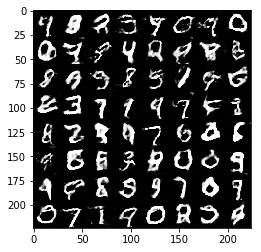

Epoch: 2/2 Discriminator Loss: 0.9780 Generator Loss: 1.0913
Epoch: 2/2 Discriminator Loss: 1.0802 Generator Loss: 2.8590
Epoch: 2/2 Discriminator Loss: 0.9097 Generator Loss: 1.4797
Epoch: 2/2 Discriminator Loss: 0.8621 Generator Loss: 1.5270
Epoch: 2/2 Discriminator Loss: 0.9051 Generator Loss: 1.4668
Epoch: 2/2 Discriminator Loss: 1.2875 Generator Loss: 0.6209
Epoch: 2/2 Discriminator Loss: 1.1262 Generator Loss: 0.8578
Epoch: 2/2 Discriminator Loss: 0.8640 Generator Loss: 1.5841
Epoch: 2/2 Discriminator Loss: 0.8413 Generator Loss: 1.3750
Epoch: 2/2 Discriminator Loss: 1.1117 Generator Loss: 0.9657


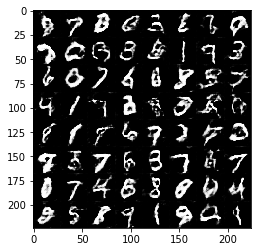

Epoch: 2/2 Discriminator Loss: 0.9361 Generator Loss: 1.2386
Epoch: 2/2 Discriminator Loss: 0.8710 Generator Loss: 1.4036
Epoch: 2/2 Discriminator Loss: 0.7195 Generator Loss: 2.4662
Epoch: 2/2 Discriminator Loss: 0.7925 Generator Loss: 1.7403
Epoch: 2/2 Discriminator Loss: 0.7990 Generator Loss: 1.6838
Epoch: 2/2 Discriminator Loss: 1.0253 Generator Loss: 2.0510
Epoch: 2/2 Discriminator Loss: 1.2571 Generator Loss: 0.6477
Epoch: 2/2 Discriminator Loss: 1.0297 Generator Loss: 0.8490
Epoch: 2/2 Discriminator Loss: 1.0297 Generator Loss: 1.4364
Epoch: 2/2 Discriminator Loss: 1.1835 Generator Loss: 0.7565


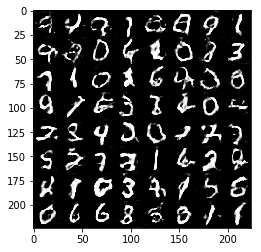

Epoch: 2/2 Discriminator Loss: 0.9083 Generator Loss: 1.3573
Epoch: 2/2 Discriminator Loss: 0.9622 Generator Loss: 1.3388
Epoch: 2/2 Discriminator Loss: 0.8788 Generator Loss: 1.5157
Epoch: 2/2 Discriminator Loss: 0.8156 Generator Loss: 2.4175
Epoch: 2/2 Discriminator Loss: 0.9450 Generator Loss: 2.0006
Epoch: 2/2 Discriminator Loss: 0.8732 Generator Loss: 1.4596
Epoch: 2/2 Discriminator Loss: 0.9114 Generator Loss: 1.2577
Epoch: 2/2 Discriminator Loss: 0.7515 Generator Loss: 1.5542
Epoch: 2/2 Discriminator Loss: 0.9199 Generator Loss: 1.2688
Epoch: 2/2 Discriminator Loss: 1.1646 Generator Loss: 0.7361


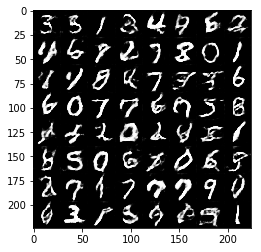

Epoch: 2/2 Discriminator Loss: 0.9403 Generator Loss: 1.0312
Epoch: 2/2 Discriminator Loss: 1.0478 Generator Loss: 1.1968
Epoch: 2/2 Discriminator Loss: 0.9916 Generator Loss: 1.3632
Epoch: 2/2 Discriminator Loss: 1.0071 Generator Loss: 1.9794
Epoch: 2/2 Discriminator Loss: 1.1633 Generator Loss: 2.6376
Epoch: 2/2 Discriminator Loss: 0.7253 Generator Loss: 1.8536
Epoch: 2/2 Discriminator Loss: 0.8547 Generator Loss: 0.9813
Epoch: 2/2 Discriminator Loss: 1.2769 Generator Loss: 0.7209
Epoch: 2/2 Discriminator Loss: 0.6588 Generator Loss: 1.9434
Epoch: 2/2 Discriminator Loss: 1.2473 Generator Loss: 0.9433


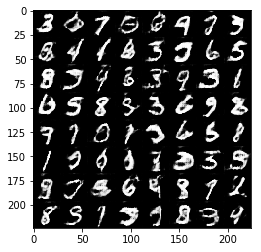

Epoch: 2/2 Discriminator Loss: 0.8903 Generator Loss: 1.5157
Epoch: 2/2 Discriminator Loss: 1.1473 Generator Loss: 1.0075
Epoch: 2/2 Discriminator Loss: 0.7830 Generator Loss: 1.7271
Epoch: 2/2 Discriminator Loss: 1.0071 Generator Loss: 1.3097
Epoch: 2/2 Discriminator Loss: 1.0936 Generator Loss: 1.5365
Epoch: 2/2 Discriminator Loss: 0.7300 Generator Loss: 1.9533
Epoch: 2/2 Discriminator Loss: 0.8234 Generator Loss: 2.2572


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch: 1/1 Discriminator Loss: 4.2412 Generator Loss: 0.0540
Epoch: 1/1 Discriminator Loss: 2.6643 Generator Loss: 0.1832
Epoch: 1/1 Discriminator Loss: 1.6272 Generator Loss: 13.4231
Epoch: 1/1 Discriminator Loss: 1.4524 Generator Loss: 8.6550
Epoch: 1/1 Discriminator Loss: 0.6495 Generator Loss: 3.0892
Epoch: 1/1 Discriminator Loss: 0.5017 Generator Loss: 5.2794
Epoch: 1/1 Discriminator Loss: 2.5024 Generator Loss: 0.1810
Epoch: 1/1 Discriminator Loss: 2.0948 Generator Loss: 8.8160
Epoch: 1/1 Discriminator Loss: 0.6702 Generator Loss: 1.9371
Epoch: 1/1 Discriminator Loss: 0.6207 Generator Loss: 3.6520


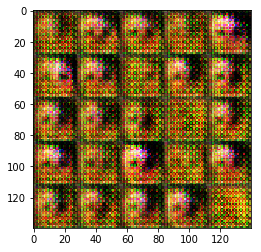

Epoch: 1/1 Discriminator Loss: 0.5991 Generator Loss: 1.8901
Epoch: 1/1 Discriminator Loss: 1.6002 Generator Loss: 0.5728
Epoch: 1/1 Discriminator Loss: 1.0489 Generator Loss: 1.3133
Epoch: 1/1 Discriminator Loss: 0.9753 Generator Loss: 1.3735
Epoch: 1/1 Discriminator Loss: 0.6891 Generator Loss: 2.4374
Epoch: 1/1 Discriminator Loss: 0.6196 Generator Loss: 2.0970
Epoch: 1/1 Discriminator Loss: 0.9909 Generator Loss: 1.1709
Epoch: 1/1 Discriminator Loss: 0.7115 Generator Loss: 1.8513
Epoch: 1/1 Discriminator Loss: 0.9502 Generator Loss: 1.7994
Epoch: 1/1 Discriminator Loss: 1.2164 Generator Loss: 0.9175


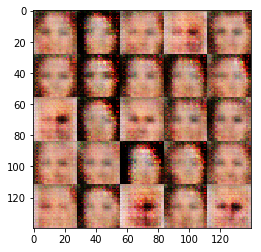

Epoch: 1/1 Discriminator Loss: 0.8615 Generator Loss: 1.4575
Epoch: 1/1 Discriminator Loss: 1.2633 Generator Loss: 0.8414
Epoch: 1/1 Discriminator Loss: 0.8083 Generator Loss: 1.8424
Epoch: 1/1 Discriminator Loss: 1.1831 Generator Loss: 0.7476
Epoch: 1/1 Discriminator Loss: 0.9356 Generator Loss: 1.9656
Epoch: 1/1 Discriminator Loss: 0.8292 Generator Loss: 1.1965
Epoch: 1/1 Discriminator Loss: 0.8605 Generator Loss: 1.6110
Epoch: 1/1 Discriminator Loss: 0.9808 Generator Loss: 1.7165
Epoch: 1/1 Discriminator Loss: 1.6791 Generator Loss: 0.5096
Epoch: 1/1 Discriminator Loss: 1.2346 Generator Loss: 0.7629


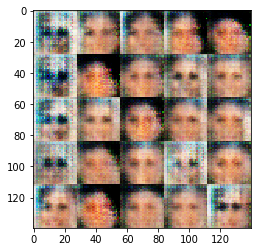

Epoch: 1/1 Discriminator Loss: 0.8205 Generator Loss: 1.7369
Epoch: 1/1 Discriminator Loss: 0.8667 Generator Loss: 1.3909
Epoch: 1/1 Discriminator Loss: 1.5516 Generator Loss: 1.2512
Epoch: 1/1 Discriminator Loss: 1.7356 Generator Loss: 0.7442
Epoch: 1/1 Discriminator Loss: 1.0473 Generator Loss: 0.9742
Epoch: 1/1 Discriminator Loss: 1.0958 Generator Loss: 2.6569
Epoch: 1/1 Discriminator Loss: 0.9375 Generator Loss: 1.7844
Epoch: 1/1 Discriminator Loss: 1.5434 Generator Loss: 0.5053
Epoch: 1/1 Discriminator Loss: 1.1832 Generator Loss: 1.5027
Epoch: 1/1 Discriminator Loss: 1.2482 Generator Loss: 1.2109


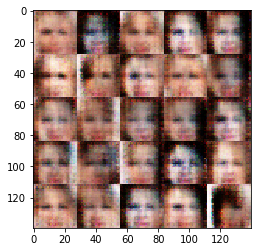

Epoch: 1/1 Discriminator Loss: 1.1184 Generator Loss: 1.8060
Epoch: 1/1 Discriminator Loss: 1.0870 Generator Loss: 0.9237
Epoch: 1/1 Discriminator Loss: 1.3811 Generator Loss: 1.7856
Epoch: 1/1 Discriminator Loss: 1.8084 Generator Loss: 2.1181
Epoch: 1/1 Discriminator Loss: 1.0933 Generator Loss: 0.7906
Epoch: 1/1 Discriminator Loss: 1.0920 Generator Loss: 1.0494
Epoch: 1/1 Discriminator Loss: 1.4280 Generator Loss: 0.5696
Epoch: 1/1 Discriminator Loss: 1.1321 Generator Loss: 1.5449
Epoch: 1/1 Discriminator Loss: 1.0978 Generator Loss: 1.0691
Epoch: 1/1 Discriminator Loss: 0.9880 Generator Loss: 1.1660


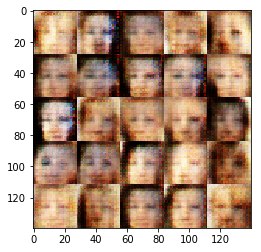

Epoch: 1/1 Discriminator Loss: 1.1844 Generator Loss: 0.9465
Epoch: 1/1 Discriminator Loss: 1.6198 Generator Loss: 0.8433
Epoch: 1/1 Discriminator Loss: 1.2072 Generator Loss: 1.0002
Epoch: 1/1 Discriminator Loss: 1.0688 Generator Loss: 0.9488
Epoch: 1/1 Discriminator Loss: 1.3319 Generator Loss: 1.1045
Epoch: 1/1 Discriminator Loss: 1.0243 Generator Loss: 0.9287
Epoch: 1/1 Discriminator Loss: 1.0580 Generator Loss: 1.0935
Epoch: 1/1 Discriminator Loss: 1.1807 Generator Loss: 0.8407
Epoch: 1/1 Discriminator Loss: 1.0789 Generator Loss: 1.3543
Epoch: 1/1 Discriminator Loss: 1.5903 Generator Loss: 0.4291


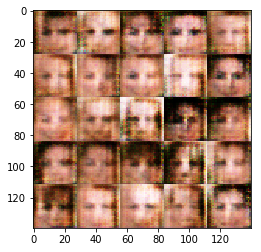

Epoch: 1/1 Discriminator Loss: 1.1208 Generator Loss: 2.0368
Epoch: 1/1 Discriminator Loss: 1.1855 Generator Loss: 0.9777
Epoch: 1/1 Discriminator Loss: 1.3721 Generator Loss: 1.1935
Epoch: 1/1 Discriminator Loss: 0.9428 Generator Loss: 1.5810
Epoch: 1/1 Discriminator Loss: 1.2678 Generator Loss: 1.2902
Epoch: 1/1 Discriminator Loss: 1.1848 Generator Loss: 1.2002
Epoch: 1/1 Discriminator Loss: 1.8202 Generator Loss: 3.6197
Epoch: 1/1 Discriminator Loss: 1.4786 Generator Loss: 0.8993
Epoch: 1/1 Discriminator Loss: 1.3161 Generator Loss: 0.7279
Epoch: 1/1 Discriminator Loss: 1.2925 Generator Loss: 1.2333


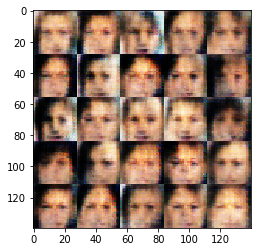

Epoch: 1/1 Discriminator Loss: 2.2309 Generator Loss: 2.9305
Epoch: 1/1 Discriminator Loss: 1.1942 Generator Loss: 1.3433
Epoch: 1/1 Discriminator Loss: 0.7999 Generator Loss: 1.2637
Epoch: 1/1 Discriminator Loss: 1.3843 Generator Loss: 0.7879
Epoch: 1/1 Discriminator Loss: 0.8420 Generator Loss: 1.5974
Epoch: 1/1 Discriminator Loss: 1.4560 Generator Loss: 0.6386
Epoch: 1/1 Discriminator Loss: 1.2789 Generator Loss: 0.8360
Epoch: 1/1 Discriminator Loss: 1.1975 Generator Loss: 1.2156
Epoch: 1/1 Discriminator Loss: 1.0016 Generator Loss: 1.1727
Epoch: 1/1 Discriminator Loss: 1.7385 Generator Loss: 1.0177


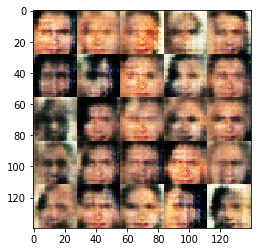

Epoch: 1/1 Discriminator Loss: 0.9210 Generator Loss: 1.1239
Epoch: 1/1 Discriminator Loss: 1.3584 Generator Loss: 0.5550
Epoch: 1/1 Discriminator Loss: 1.1055 Generator Loss: 1.1673
Epoch: 1/1 Discriminator Loss: 0.9615 Generator Loss: 1.3671
Epoch: 1/1 Discriminator Loss: 1.2626 Generator Loss: 1.0164
Epoch: 1/1 Discriminator Loss: 1.1284 Generator Loss: 1.1252
Epoch: 1/1 Discriminator Loss: 1.1969 Generator Loss: 0.8982
Epoch: 1/1 Discriminator Loss: 1.2006 Generator Loss: 0.6445
Epoch: 1/1 Discriminator Loss: 1.2545 Generator Loss: 0.8077
Epoch: 1/1 Discriminator Loss: 1.5679 Generator Loss: 0.5974


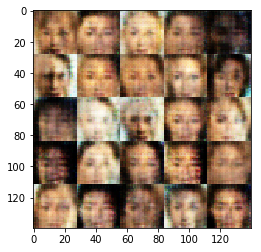

Epoch: 1/1 Discriminator Loss: 1.0722 Generator Loss: 0.7619
Epoch: 1/1 Discriminator Loss: 1.2112 Generator Loss: 1.0622
Epoch: 1/1 Discriminator Loss: 1.3118 Generator Loss: 0.7169
Epoch: 1/1 Discriminator Loss: 1.0504 Generator Loss: 1.2271
Epoch: 1/1 Discriminator Loss: 1.5037 Generator Loss: 0.9934
Epoch: 1/1 Discriminator Loss: 1.3384 Generator Loss: 0.6896
Epoch: 1/1 Discriminator Loss: 2.0126 Generator Loss: 2.5151
Epoch: 1/1 Discriminator Loss: 1.3203 Generator Loss: 1.0016
Epoch: 1/1 Discriminator Loss: 1.0547 Generator Loss: 1.3306
Epoch: 1/1 Discriminator Loss: 1.3110 Generator Loss: 1.1265


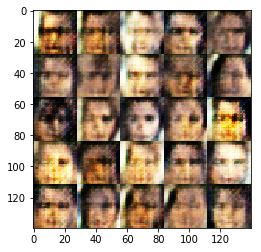

Epoch: 1/1 Discriminator Loss: 0.9855 Generator Loss: 1.1471
Epoch: 1/1 Discriminator Loss: 1.3705 Generator Loss: 0.9851
Epoch: 1/1 Discriminator Loss: 1.2364 Generator Loss: 0.8755
Epoch: 1/1 Discriminator Loss: 1.2157 Generator Loss: 1.9142
Epoch: 1/1 Discriminator Loss: 0.9966 Generator Loss: 1.3559
Epoch: 1/1 Discriminator Loss: 1.2387 Generator Loss: 1.3099
Epoch: 1/1 Discriminator Loss: 1.1083 Generator Loss: 1.2118
Epoch: 1/1 Discriminator Loss: 1.2118 Generator Loss: 0.9087
Epoch: 1/1 Discriminator Loss: 1.6027 Generator Loss: 0.9119
Epoch: 1/1 Discriminator Loss: 0.9492 Generator Loss: 1.2416


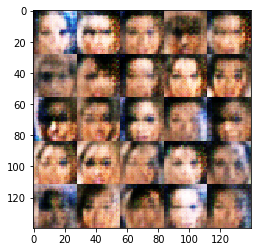

Epoch: 1/1 Discriminator Loss: 1.0914 Generator Loss: 1.0727
Epoch: 1/1 Discriminator Loss: 0.8875 Generator Loss: 1.3796
Epoch: 1/1 Discriminator Loss: 1.1313 Generator Loss: 0.7810
Epoch: 1/1 Discriminator Loss: 1.3685 Generator Loss: 1.0766
Epoch: 1/1 Discriminator Loss: 1.1864 Generator Loss: 0.9055
Epoch: 1/1 Discriminator Loss: 1.3701 Generator Loss: 0.7429
Epoch: 1/1 Discriminator Loss: 1.2749 Generator Loss: 0.9569
Epoch: 1/1 Discriminator Loss: 1.1435 Generator Loss: 0.9574
Epoch: 1/1 Discriminator Loss: 1.3451 Generator Loss: 0.7591
Epoch: 1/1 Discriminator Loss: 1.1998 Generator Loss: 1.1694


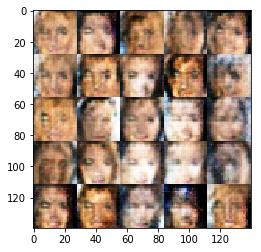

Epoch: 1/1 Discriminator Loss: 1.1267 Generator Loss: 1.4881
Epoch: 1/1 Discriminator Loss: 1.0881 Generator Loss: 1.8503
Epoch: 1/1 Discriminator Loss: 1.1793 Generator Loss: 1.8344
Epoch: 1/1 Discriminator Loss: 1.2172 Generator Loss: 0.9011
Epoch: 1/1 Discriminator Loss: 1.0510 Generator Loss: 0.9640
Epoch: 1/1 Discriminator Loss: 1.0592 Generator Loss: 0.9759
Epoch: 1/1 Discriminator Loss: 1.1843 Generator Loss: 1.5711
Epoch: 1/1 Discriminator Loss: 1.4748 Generator Loss: 2.1326
Epoch: 1/1 Discriminator Loss: 1.2239 Generator Loss: 1.0051
Epoch: 1/1 Discriminator Loss: 1.2041 Generator Loss: 1.3643


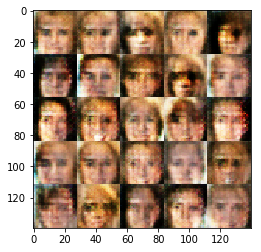

Epoch: 1/1 Discriminator Loss: 1.1425 Generator Loss: 1.2974
Epoch: 1/1 Discriminator Loss: 0.9954 Generator Loss: 1.0330
Epoch: 1/1 Discriminator Loss: 1.3694 Generator Loss: 1.0134
Epoch: 1/1 Discriminator Loss: 1.2621 Generator Loss: 1.4796
Epoch: 1/1 Discriminator Loss: 1.3528 Generator Loss: 0.6812
Epoch: 1/1 Discriminator Loss: 1.2291 Generator Loss: 1.5853
Epoch: 1/1 Discriminator Loss: 1.2711 Generator Loss: 1.1741
Epoch: 1/1 Discriminator Loss: 0.8103 Generator Loss: 1.4515
Epoch: 1/1 Discriminator Loss: 1.1270 Generator Loss: 1.3348
Epoch: 1/1 Discriminator Loss: 1.1797 Generator Loss: 1.0009


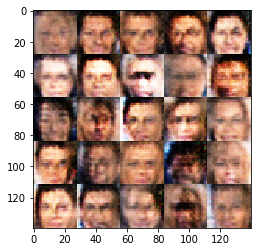

Epoch: 1/1 Discriminator Loss: 1.2779 Generator Loss: 0.6336
Epoch: 1/1 Discriminator Loss: 1.3792 Generator Loss: 0.5233
Epoch: 1/1 Discriminator Loss: 1.4289 Generator Loss: 0.6277
Epoch: 1/1 Discriminator Loss: 0.9995 Generator Loss: 1.2788
Epoch: 1/1 Discriminator Loss: 1.0971 Generator Loss: 1.0449
Epoch: 1/1 Discriminator Loss: 1.3203 Generator Loss: 1.6471
Epoch: 1/1 Discriminator Loss: 0.9699 Generator Loss: 1.7337
Epoch: 1/1 Discriminator Loss: 1.0447 Generator Loss: 1.1413
Epoch: 1/1 Discriminator Loss: 1.3097 Generator Loss: 0.9923
Epoch: 1/1 Discriminator Loss: 1.1954 Generator Loss: 1.0540


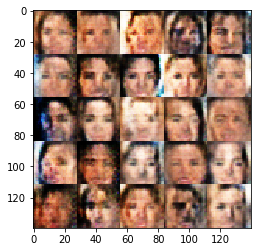

Epoch: 1/1 Discriminator Loss: 1.2202 Generator Loss: 0.9973
Epoch: 1/1 Discriminator Loss: 1.5456 Generator Loss: 0.4998
Epoch: 1/1 Discriminator Loss: 1.2773 Generator Loss: 0.8952
Epoch: 1/1 Discriminator Loss: 1.3802 Generator Loss: 1.2416
Epoch: 1/1 Discriminator Loss: 1.3719 Generator Loss: 1.0148
Epoch: 1/1 Discriminator Loss: 1.3962 Generator Loss: 2.1879
Epoch: 1/1 Discriminator Loss: 1.1645 Generator Loss: 0.9401
Epoch: 1/1 Discriminator Loss: 1.2711 Generator Loss: 0.6361
Epoch: 1/1 Discriminator Loss: 1.1599 Generator Loss: 1.2146
Epoch: 1/1 Discriminator Loss: 1.3127 Generator Loss: 0.9746


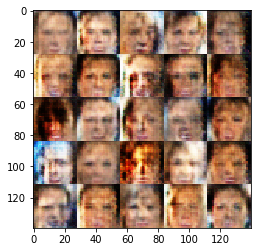

Epoch: 1/1 Discriminator Loss: 1.2834 Generator Loss: 1.2315
Epoch: 1/1 Discriminator Loss: 1.1665 Generator Loss: 1.2200
Epoch: 1/1 Discriminator Loss: 1.1059 Generator Loss: 2.1323
Epoch: 1/1 Discriminator Loss: 1.0601 Generator Loss: 1.6216
Epoch: 1/1 Discriminator Loss: 1.2289 Generator Loss: 0.7407
Epoch: 1/1 Discriminator Loss: 1.1540 Generator Loss: 1.3496
Epoch: 1/1 Discriminator Loss: 1.0882 Generator Loss: 1.0468
Epoch: 1/1 Discriminator Loss: 1.1445 Generator Loss: 0.8502
Epoch: 1/1 Discriminator Loss: 1.4806 Generator Loss: 0.5401
Epoch: 1/1 Discriminator Loss: 1.3280 Generator Loss: 0.6812


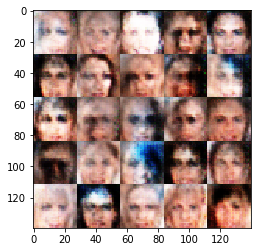

Epoch: 1/1 Discriminator Loss: 1.5052 Generator Loss: 1.1355
Epoch: 1/1 Discriminator Loss: 1.0878 Generator Loss: 0.9400
Epoch: 1/1 Discriminator Loss: 1.1603 Generator Loss: 1.4625
Epoch: 1/1 Discriminator Loss: 1.2097 Generator Loss: 1.0150
Epoch: 1/1 Discriminator Loss: 1.2996 Generator Loss: 0.8436
Epoch: 1/1 Discriminator Loss: 1.1650 Generator Loss: 1.2373
Epoch: 1/1 Discriminator Loss: 0.9611 Generator Loss: 1.3300
Epoch: 1/1 Discriminator Loss: 1.1417 Generator Loss: 1.3680
Epoch: 1/1 Discriminator Loss: 1.2393 Generator Loss: 1.6954
Epoch: 1/1 Discriminator Loss: 1.1722 Generator Loss: 1.6371


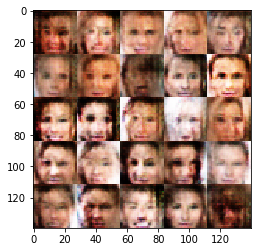

Epoch: 1/1 Discriminator Loss: 1.0320 Generator Loss: 1.2869
Epoch: 1/1 Discriminator Loss: 1.0610 Generator Loss: 1.1322
Epoch: 1/1 Discriminator Loss: 1.2551 Generator Loss: 0.9886
Epoch: 1/1 Discriminator Loss: 1.1332 Generator Loss: 0.8439
Epoch: 1/1 Discriminator Loss: 1.2716 Generator Loss: 0.7379
Epoch: 1/1 Discriminator Loss: 1.3222 Generator Loss: 1.6204
Epoch: 1/1 Discriminator Loss: 1.1733 Generator Loss: 0.7346
Epoch: 1/1 Discriminator Loss: 1.1118 Generator Loss: 1.2697
Epoch: 1/1 Discriminator Loss: 0.9576 Generator Loss: 1.2915
Epoch: 1/1 Discriminator Loss: 1.2222 Generator Loss: 0.8985


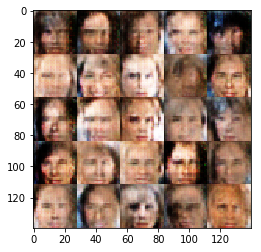

Epoch: 1/1 Discriminator Loss: 1.2968 Generator Loss: 0.8550
Epoch: 1/1 Discriminator Loss: 1.0768 Generator Loss: 1.0220
Epoch: 1/1 Discriminator Loss: 1.2464 Generator Loss: 0.9002
Epoch: 1/1 Discriminator Loss: 0.9569 Generator Loss: 1.1608
Epoch: 1/1 Discriminator Loss: 1.2282 Generator Loss: 1.2097
Epoch: 1/1 Discriminator Loss: 1.2410 Generator Loss: 0.7667
Epoch: 1/1 Discriminator Loss: 1.1282 Generator Loss: 1.0174
Epoch: 1/1 Discriminator Loss: 1.1080 Generator Loss: 1.3461
Epoch: 1/1 Discriminator Loss: 1.1435 Generator Loss: 1.0415
Epoch: 1/1 Discriminator Loss: 1.0299 Generator Loss: 1.4694


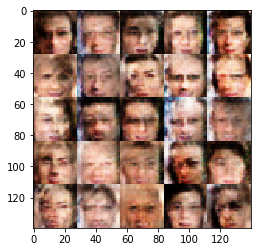

Epoch: 1/1 Discriminator Loss: 1.2517 Generator Loss: 0.9893
Epoch: 1/1 Discriminator Loss: 1.2828 Generator Loss: 1.0627
Epoch: 1/1 Discriminator Loss: 1.3376 Generator Loss: 0.6505
Epoch: 1/1 Discriminator Loss: 1.0425 Generator Loss: 1.1796
Epoch: 1/1 Discriminator Loss: 1.0558 Generator Loss: 1.9034
Epoch: 1/1 Discriminator Loss: 1.2305 Generator Loss: 1.0471
Epoch: 1/1 Discriminator Loss: 1.1867 Generator Loss: 1.0640
Epoch: 1/1 Discriminator Loss: 1.0499 Generator Loss: 1.3101
Epoch: 1/1 Discriminator Loss: 1.2911 Generator Loss: 0.7461
Epoch: 1/1 Discriminator Loss: 1.0182 Generator Loss: 1.5367


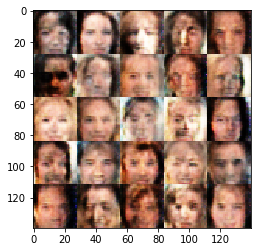

Epoch: 1/1 Discriminator Loss: 1.4036 Generator Loss: 1.0455
Epoch: 1/1 Discriminator Loss: 1.3025 Generator Loss: 1.0897
Epoch: 1/1 Discriminator Loss: 1.1828 Generator Loss: 0.9079
Epoch: 1/1 Discriminator Loss: 1.2203 Generator Loss: 1.3052
Epoch: 1/1 Discriminator Loss: 1.4352 Generator Loss: 0.7971
Epoch: 1/1 Discriminator Loss: 1.3171 Generator Loss: 0.6515
Epoch: 1/1 Discriminator Loss: 1.2391 Generator Loss: 0.8101
Epoch: 1/1 Discriminator Loss: 1.0354 Generator Loss: 1.1544
Epoch: 1/1 Discriminator Loss: 1.2280 Generator Loss: 0.8726
Epoch: 1/1 Discriminator Loss: 1.1288 Generator Loss: 1.1897


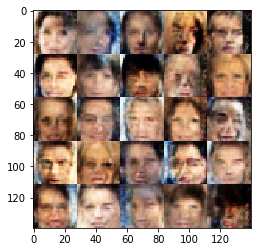

Epoch: 1/1 Discriminator Loss: 1.2757 Generator Loss: 0.7583
Epoch: 1/1 Discriminator Loss: 1.2353 Generator Loss: 1.0564
Epoch: 1/1 Discriminator Loss: 1.0929 Generator Loss: 1.4686
Epoch: 1/1 Discriminator Loss: 1.2247 Generator Loss: 1.0086
Epoch: 1/1 Discriminator Loss: 1.4336 Generator Loss: 0.6544
Epoch: 1/1 Discriminator Loss: 1.0371 Generator Loss: 1.0864
Epoch: 1/1 Discriminator Loss: 1.1167 Generator Loss: 1.1423
Epoch: 1/1 Discriminator Loss: 1.1477 Generator Loss: 0.9544
Epoch: 1/1 Discriminator Loss: 1.0135 Generator Loss: 1.2197
Epoch: 1/1 Discriminator Loss: 1.3761 Generator Loss: 1.8562


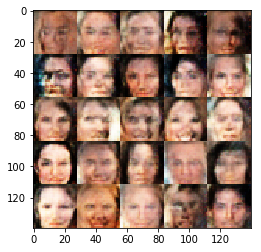

Epoch: 1/1 Discriminator Loss: 1.1170 Generator Loss: 1.1921
Epoch: 1/1 Discriminator Loss: 1.2024 Generator Loss: 1.3096
Epoch: 1/1 Discriminator Loss: 1.2683 Generator Loss: 1.0301
Epoch: 1/1 Discriminator Loss: 1.1909 Generator Loss: 1.4675
Epoch: 1/1 Discriminator Loss: 1.0913 Generator Loss: 1.0741
Epoch: 1/1 Discriminator Loss: 1.2908 Generator Loss: 0.6369
Epoch: 1/1 Discriminator Loss: 1.1379 Generator Loss: 1.2315
Epoch: 1/1 Discriminator Loss: 1.1195 Generator Loss: 1.2974
Epoch: 1/1 Discriminator Loss: 1.2729 Generator Loss: 1.3138
Epoch: 1/1 Discriminator Loss: 1.1330 Generator Loss: 1.6049


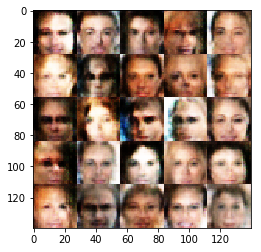

Epoch: 1/1 Discriminator Loss: 1.1192 Generator Loss: 0.7930
Epoch: 1/1 Discriminator Loss: 1.2209 Generator Loss: 0.8849
Epoch: 1/1 Discriminator Loss: 1.1753 Generator Loss: 1.0472
Epoch: 1/1 Discriminator Loss: 1.2475 Generator Loss: 1.2760
Epoch: 1/1 Discriminator Loss: 1.3380 Generator Loss: 0.6218
Epoch: 1/1 Discriminator Loss: 1.0511 Generator Loss: 1.2007
Epoch: 1/1 Discriminator Loss: 1.3007 Generator Loss: 0.9438
Epoch: 1/1 Discriminator Loss: 1.4183 Generator Loss: 1.7655
Epoch: 1/1 Discriminator Loss: 1.2807 Generator Loss: 0.6945
Epoch: 1/1 Discriminator Loss: 1.1483 Generator Loss: 1.0380


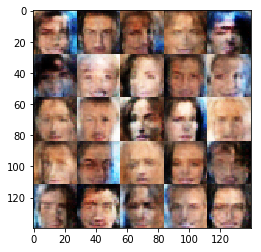

Epoch: 1/1 Discriminator Loss: 1.1897 Generator Loss: 1.1603
Epoch: 1/1 Discriminator Loss: 1.1025 Generator Loss: 1.3350
Epoch: 1/1 Discriminator Loss: 0.9117 Generator Loss: 1.1450
Epoch: 1/1 Discriminator Loss: 1.2459 Generator Loss: 0.9999
Epoch: 1/1 Discriminator Loss: 1.0517 Generator Loss: 0.8480
Epoch: 1/1 Discriminator Loss: 1.2659 Generator Loss: 0.8475
Epoch: 1/1 Discriminator Loss: 1.1551 Generator Loss: 0.9828
Epoch: 1/1 Discriminator Loss: 1.1991 Generator Loss: 0.8450
Epoch: 1/1 Discriminator Loss: 1.3436 Generator Loss: 0.8387
Epoch: 1/1 Discriminator Loss: 0.9894 Generator Loss: 1.1431


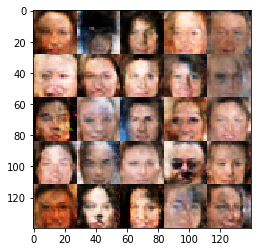

Epoch: 1/1 Discriminator Loss: 1.3407 Generator Loss: 0.5966
Epoch: 1/1 Discriminator Loss: 1.2345 Generator Loss: 0.9709
Epoch: 1/1 Discriminator Loss: 1.1617 Generator Loss: 1.2029
Epoch: 1/1 Discriminator Loss: 1.1430 Generator Loss: 1.2582
Epoch: 1/1 Discriminator Loss: 1.0257 Generator Loss: 1.1896
Epoch: 1/1 Discriminator Loss: 1.0550 Generator Loss: 1.0129
Epoch: 1/1 Discriminator Loss: 1.4450 Generator Loss: 1.8238
Epoch: 1/1 Discriminator Loss: 1.2338 Generator Loss: 1.1193
Epoch: 1/1 Discriminator Loss: 1.2068 Generator Loss: 1.5329
Epoch: 1/1 Discriminator Loss: 1.4048 Generator Loss: 0.7530


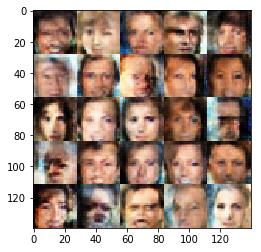

Epoch: 1/1 Discriminator Loss: 1.1667 Generator Loss: 0.9621
Epoch: 1/1 Discriminator Loss: 1.2828 Generator Loss: 0.7984
Epoch: 1/1 Discriminator Loss: 1.2051 Generator Loss: 0.8644
Epoch: 1/1 Discriminator Loss: 1.4061 Generator Loss: 1.1212
Epoch: 1/1 Discriminator Loss: 1.3997 Generator Loss: 0.7566
Epoch: 1/1 Discriminator Loss: 1.2604 Generator Loss: 1.1891
Epoch: 1/1 Discriminator Loss: 1.2767 Generator Loss: 0.9409
Epoch: 1/1 Discriminator Loss: 1.1430 Generator Loss: 0.9609
Epoch: 1/1 Discriminator Loss: 1.2861 Generator Loss: 0.5755
Epoch: 1/1 Discriminator Loss: 1.2445 Generator Loss: 0.8038


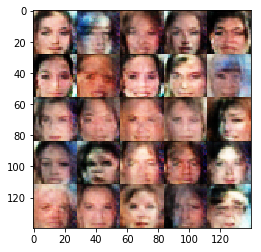

Epoch: 1/1 Discriminator Loss: 1.2419 Generator Loss: 1.1553
Epoch: 1/1 Discriminator Loss: 1.2411 Generator Loss: 1.0443
Epoch: 1/1 Discriminator Loss: 1.0924 Generator Loss: 1.7460
Epoch: 1/1 Discriminator Loss: 1.3038 Generator Loss: 0.8408
Epoch: 1/1 Discriminator Loss: 1.1013 Generator Loss: 1.2077
Epoch: 1/1 Discriminator Loss: 1.1951 Generator Loss: 0.8788
Epoch: 1/1 Discriminator Loss: 1.3110 Generator Loss: 1.6518
Epoch: 1/1 Discriminator Loss: 1.2259 Generator Loss: 0.9052
Epoch: 1/1 Discriminator Loss: 1.3766 Generator Loss: 1.2703
Epoch: 1/1 Discriminator Loss: 1.1660 Generator Loss: 0.9858


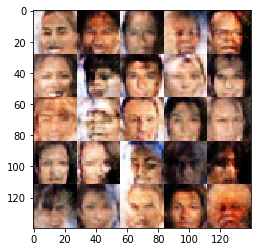

Epoch: 1/1 Discriminator Loss: 1.2927 Generator Loss: 1.4899
Epoch: 1/1 Discriminator Loss: 1.5709 Generator Loss: 0.6123
Epoch: 1/1 Discriminator Loss: 1.1523 Generator Loss: 1.1555
Epoch: 1/1 Discriminator Loss: 1.1457 Generator Loss: 1.2233
Epoch: 1/1 Discriminator Loss: 1.3051 Generator Loss: 0.8167
Epoch: 1/1 Discriminator Loss: 1.1462 Generator Loss: 0.9124
Epoch: 1/1 Discriminator Loss: 1.1109 Generator Loss: 1.2623
Epoch: 1/1 Discriminator Loss: 1.1237 Generator Loss: 0.7650
Epoch: 1/1 Discriminator Loss: 1.0064 Generator Loss: 1.1308
Epoch: 1/1 Discriminator Loss: 1.1630 Generator Loss: 0.8703


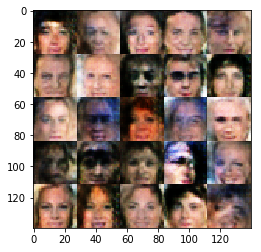

Epoch: 1/1 Discriminator Loss: 1.2261 Generator Loss: 1.2272
Epoch: 1/1 Discriminator Loss: 1.1042 Generator Loss: 1.1971
Epoch: 1/1 Discriminator Loss: 1.0982 Generator Loss: 1.1103
Epoch: 1/1 Discriminator Loss: 1.1157 Generator Loss: 0.7742
Epoch: 1/1 Discriminator Loss: 1.1635 Generator Loss: 1.1091
Epoch: 1/1 Discriminator Loss: 1.3540 Generator Loss: 0.7771
Epoch: 1/1 Discriminator Loss: 1.1352 Generator Loss: 1.0510
Epoch: 1/1 Discriminator Loss: 1.0533 Generator Loss: 1.2050
Epoch: 1/1 Discriminator Loss: 1.4860 Generator Loss: 0.4563
Epoch: 1/1 Discriminator Loss: 1.2714 Generator Loss: 1.1201


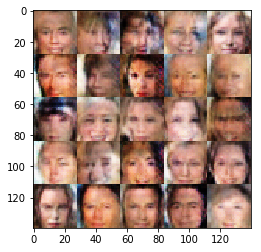

Epoch: 1/1 Discriminator Loss: 1.2034 Generator Loss: 0.8411
Epoch: 1/1 Discriminator Loss: 0.9398 Generator Loss: 1.2000
Epoch: 1/1 Discriminator Loss: 1.1524 Generator Loss: 1.2898
Epoch: 1/1 Discriminator Loss: 1.2088 Generator Loss: 0.9277
Epoch: 1/1 Discriminator Loss: 1.2584 Generator Loss: 0.7023
Epoch: 1/1 Discriminator Loss: 1.1416 Generator Loss: 0.9678
Epoch: 1/1 Discriminator Loss: 1.1425 Generator Loss: 0.8451
Epoch: 1/1 Discriminator Loss: 1.4291 Generator Loss: 1.4122
Epoch: 1/1 Discriminator Loss: 1.4128 Generator Loss: 0.6040
Epoch: 1/1 Discriminator Loss: 1.2943 Generator Loss: 0.6936


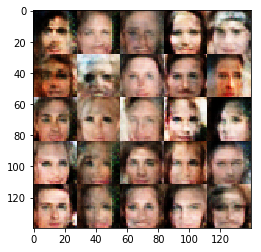

Epoch: 1/1 Discriminator Loss: 1.0733 Generator Loss: 1.0753
Epoch: 1/1 Discriminator Loss: 1.2157 Generator Loss: 0.6788
Epoch: 1/1 Discriminator Loss: 1.5222 Generator Loss: 0.5514
Epoch: 1/1 Discriminator Loss: 1.1557 Generator Loss: 1.0951
Epoch: 1/1 Discriminator Loss: 1.2391 Generator Loss: 0.7870
Epoch: 1/1 Discriminator Loss: 1.2332 Generator Loss: 0.7278
Epoch: 1/1 Discriminator Loss: 1.2959 Generator Loss: 1.0787
Epoch: 1/1 Discriminator Loss: 1.2359 Generator Loss: 1.0028
Epoch: 1/1 Discriminator Loss: 1.1923 Generator Loss: 0.7170
Epoch: 1/1 Discriminator Loss: 1.2206 Generator Loss: 1.5141


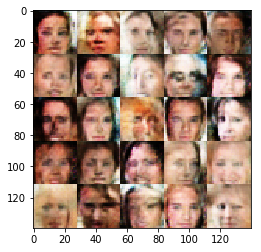

Epoch: 1/1 Discriminator Loss: 1.1342 Generator Loss: 1.1633
Epoch: 1/1 Discriminator Loss: 1.3487 Generator Loss: 1.6305
Epoch: 1/1 Discriminator Loss: 1.2053 Generator Loss: 1.0945
Epoch: 1/1 Discriminator Loss: 1.0693 Generator Loss: 0.9261
Epoch: 1/1 Discriminator Loss: 1.1658 Generator Loss: 1.2007
Epoch: 1/1 Discriminator Loss: 1.2315 Generator Loss: 1.3134
Epoch: 1/1 Discriminator Loss: 1.1758 Generator Loss: 1.2621
Epoch: 1/1 Discriminator Loss: 1.0758 Generator Loss: 1.1984
Epoch: 1/1 Discriminator Loss: 1.4723 Generator Loss: 1.4218
Epoch: 1/1 Discriminator Loss: 1.1609 Generator Loss: 0.9350


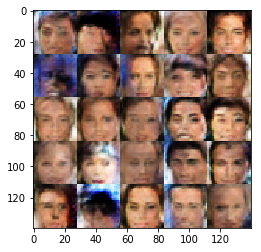

Epoch: 1/1 Discriminator Loss: 0.9581 Generator Loss: 1.3610
Epoch: 1/1 Discriminator Loss: 1.0201 Generator Loss: 1.1223
Epoch: 1/1 Discriminator Loss: 1.6477 Generator Loss: 0.7365
Epoch: 1/1 Discriminator Loss: 1.0996 Generator Loss: 1.1381
Epoch: 1/1 Discriminator Loss: 1.4031 Generator Loss: 0.6474
Epoch: 1/1 Discriminator Loss: 1.1278 Generator Loss: 0.8891
Epoch: 1/1 Discriminator Loss: 1.0723 Generator Loss: 1.1360
Epoch: 1/1 Discriminator Loss: 1.1412 Generator Loss: 0.9412
Epoch: 1/1 Discriminator Loss: 1.1205 Generator Loss: 1.1262
Epoch: 1/1 Discriminator Loss: 1.1388 Generator Loss: 0.8798


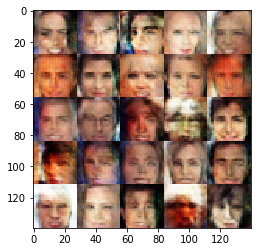

Epoch: 1/1 Discriminator Loss: 1.0337 Generator Loss: 1.0844
Epoch: 1/1 Discriminator Loss: 1.2303 Generator Loss: 0.6940
Epoch: 1/1 Discriminator Loss: 1.3179 Generator Loss: 0.7498
Epoch: 1/1 Discriminator Loss: 1.2601 Generator Loss: 0.6322
Epoch: 1/1 Discriminator Loss: 1.2638 Generator Loss: 0.8246
Epoch: 1/1 Discriminator Loss: 1.1195 Generator Loss: 0.9363
Epoch: 1/1 Discriminator Loss: 0.9918 Generator Loss: 1.3466
Epoch: 1/1 Discriminator Loss: 0.9345 Generator Loss: 1.1970
Epoch: 1/1 Discriminator Loss: 1.0928 Generator Loss: 1.2764
Epoch: 1/1 Discriminator Loss: 1.8520 Generator Loss: 2.3660


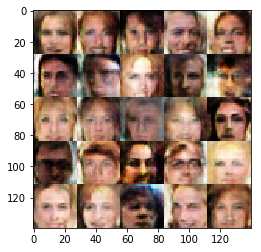

Epoch: 1/1 Discriminator Loss: 1.3116 Generator Loss: 0.5763
Epoch: 1/1 Discriminator Loss: 1.0732 Generator Loss: 1.0484
Epoch: 1/1 Discriminator Loss: 1.1365 Generator Loss: 0.8834
Epoch: 1/1 Discriminator Loss: 1.1420 Generator Loss: 1.2132
Epoch: 1/1 Discriminator Loss: 1.0216 Generator Loss: 1.1999
Epoch: 1/1 Discriminator Loss: 1.0268 Generator Loss: 1.0093
Epoch: 1/1 Discriminator Loss: 1.1784 Generator Loss: 1.0957
Epoch: 1/1 Discriminator Loss: 0.9206 Generator Loss: 1.4628
Epoch: 1/1 Discriminator Loss: 1.1566 Generator Loss: 0.8717
Epoch: 1/1 Discriminator Loss: 1.1853 Generator Loss: 1.3047


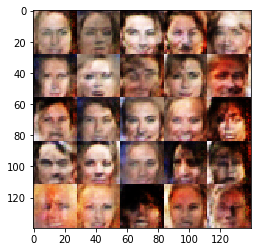

Epoch: 1/1 Discriminator Loss: 1.2714 Generator Loss: 0.8344
Epoch: 1/1 Discriminator Loss: 1.1733 Generator Loss: 1.1421
Epoch: 1/1 Discriminator Loss: 1.2350 Generator Loss: 1.0202
Epoch: 1/1 Discriminator Loss: 1.2594 Generator Loss: 0.5161
Epoch: 1/1 Discriminator Loss: 1.1932 Generator Loss: 1.1941
Epoch: 1/1 Discriminator Loss: 1.4798 Generator Loss: 0.6623
Epoch: 1/1 Discriminator Loss: 1.1614 Generator Loss: 1.3812
Epoch: 1/1 Discriminator Loss: 1.5012 Generator Loss: 0.5663
Epoch: 1/1 Discriminator Loss: 1.5423 Generator Loss: 0.4253
Epoch: 1/1 Discriminator Loss: 1.3129 Generator Loss: 1.3571


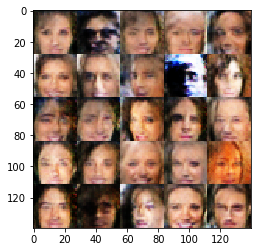

Epoch: 1/1 Discriminator Loss: 1.1882 Generator Loss: 1.0877
Epoch: 1/1 Discriminator Loss: 1.2905 Generator Loss: 0.9625
Epoch: 1/1 Discriminator Loss: 1.0602 Generator Loss: 1.2098
Epoch: 1/1 Discriminator Loss: 1.3206 Generator Loss: 1.1737
Epoch: 1/1 Discriminator Loss: 1.3156 Generator Loss: 0.6179
Epoch: 1/1 Discriminator Loss: 1.1524 Generator Loss: 1.1858
Epoch: 1/1 Discriminator Loss: 1.1287 Generator Loss: 0.8345
Epoch: 1/1 Discriminator Loss: 1.2991 Generator Loss: 0.7317
Epoch: 1/1 Discriminator Loss: 1.0674 Generator Loss: 1.1628
Epoch: 1/1 Discriminator Loss: 1.1591 Generator Loss: 1.4697


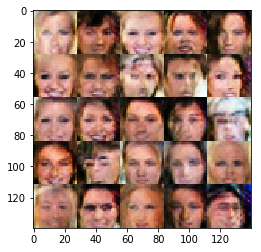

Epoch: 1/1 Discriminator Loss: 1.2170 Generator Loss: 1.1012
Epoch: 1/1 Discriminator Loss: 1.1874 Generator Loss: 1.2739
Epoch: 1/1 Discriminator Loss: 1.1954 Generator Loss: 1.2584
Epoch: 1/1 Discriminator Loss: 1.4013 Generator Loss: 1.1909
Epoch: 1/1 Discriminator Loss: 1.1535 Generator Loss: 1.0228
Epoch: 1/1 Discriminator Loss: 1.1445 Generator Loss: 1.1656
Epoch: 1/1 Discriminator Loss: 1.2759 Generator Loss: 0.7724
Epoch: 1/1 Discriminator Loss: 1.3266 Generator Loss: 0.9510
Epoch: 1/1 Discriminator Loss: 1.3180 Generator Loss: 0.8607
Epoch: 1/1 Discriminator Loss: 1.1109 Generator Loss: 1.0002


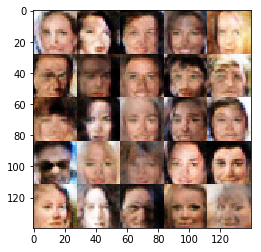

Epoch: 1/1 Discriminator Loss: 1.0685 Generator Loss: 0.9942
Epoch: 1/1 Discriminator Loss: 1.0864 Generator Loss: 0.9489
Epoch: 1/1 Discriminator Loss: 1.2087 Generator Loss: 0.8866
Epoch: 1/1 Discriminator Loss: 1.1080 Generator Loss: 1.2200
Epoch: 1/1 Discriminator Loss: 1.2041 Generator Loss: 1.1110
Epoch: 1/1 Discriminator Loss: 1.2749 Generator Loss: 0.6913
Epoch: 1/1 Discriminator Loss: 1.0291 Generator Loss: 1.0922
Epoch: 1/1 Discriminator Loss: 1.1841 Generator Loss: 1.0102
Epoch: 1/1 Discriminator Loss: 1.1217 Generator Loss: 1.2899
Epoch: 1/1 Discriminator Loss: 1.1111 Generator Loss: 0.9232


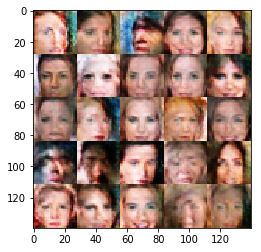

Epoch: 1/1 Discriminator Loss: 1.0885 Generator Loss: 1.6705
Epoch: 1/1 Discriminator Loss: 1.1650 Generator Loss: 0.8375
Epoch: 1/1 Discriminator Loss: 1.0714 Generator Loss: 1.4153
Epoch: 1/1 Discriminator Loss: 1.0213 Generator Loss: 1.1477
Epoch: 1/1 Discriminator Loss: 1.2430 Generator Loss: 0.8427
Epoch: 1/1 Discriminator Loss: 1.3309 Generator Loss: 0.7994
Epoch: 1/1 Discriminator Loss: 1.3704 Generator Loss: 0.9995
Epoch: 1/1 Discriminator Loss: 1.0935 Generator Loss: 1.2049
Epoch: 1/1 Discriminator Loss: 1.1338 Generator Loss: 1.4691
Epoch: 1/1 Discriminator Loss: 1.2376 Generator Loss: 0.7369


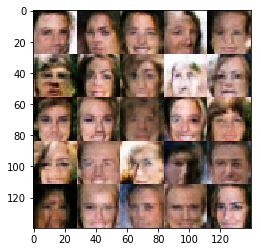

Epoch: 1/1 Discriminator Loss: 1.0511 Generator Loss: 1.4947
Epoch: 1/1 Discriminator Loss: 1.2356 Generator Loss: 0.7624
Epoch: 1/1 Discriminator Loss: 1.2955 Generator Loss: 0.7354
Epoch: 1/1 Discriminator Loss: 0.9890 Generator Loss: 1.3084
Epoch: 1/1 Discriminator Loss: 0.9282 Generator Loss: 1.5163
Epoch: 1/1 Discriminator Loss: 0.9634 Generator Loss: 1.1304
Epoch: 1/1 Discriminator Loss: 1.2821 Generator Loss: 1.1035
Epoch: 1/1 Discriminator Loss: 1.0943 Generator Loss: 0.9153
Epoch: 1/1 Discriminator Loss: 1.1014 Generator Loss: 0.8571
Epoch: 1/1 Discriminator Loss: 1.3301 Generator Loss: 1.3651


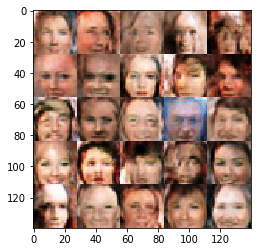

Epoch: 1/1 Discriminator Loss: 1.6434 Generator Loss: 0.8895
Epoch: 1/1 Discriminator Loss: 1.3790 Generator Loss: 0.7591
Epoch: 1/1 Discriminator Loss: 1.0314 Generator Loss: 1.1365
Epoch: 1/1 Discriminator Loss: 1.1682 Generator Loss: 1.0033
Epoch: 1/1 Discriminator Loss: 1.4114 Generator Loss: 0.5874
Epoch: 1/1 Discriminator Loss: 1.1872 Generator Loss: 0.7316
Epoch: 1/1 Discriminator Loss: 1.0288 Generator Loss: 0.8707
Epoch: 1/1 Discriminator Loss: 1.0811 Generator Loss: 0.7936
Epoch: 1/1 Discriminator Loss: 1.0930 Generator Loss: 1.1325
Epoch: 1/1 Discriminator Loss: 1.0716 Generator Loss: 0.9785


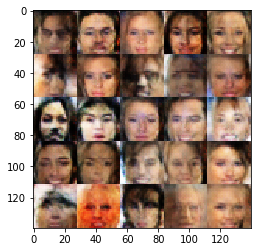

Epoch: 1/1 Discriminator Loss: 1.0111 Generator Loss: 0.9991
Epoch: 1/1 Discriminator Loss: 1.1683 Generator Loss: 1.1740
Epoch: 1/1 Discriminator Loss: 1.0368 Generator Loss: 1.0578
Epoch: 1/1 Discriminator Loss: 1.1510 Generator Loss: 1.0562
Epoch: 1/1 Discriminator Loss: 1.2305 Generator Loss: 0.8790
Epoch: 1/1 Discriminator Loss: 1.2209 Generator Loss: 0.8061
Epoch: 1/1 Discriminator Loss: 0.9901 Generator Loss: 1.0048
Epoch: 1/1 Discriminator Loss: 1.2506 Generator Loss: 1.2163
Epoch: 1/1 Discriminator Loss: 1.0280 Generator Loss: 0.9876
Epoch: 1/1 Discriminator Loss: 1.1288 Generator Loss: 0.9407


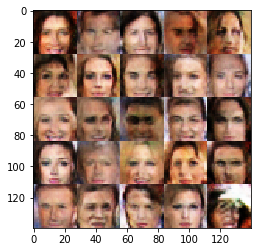

Epoch: 1/1 Discriminator Loss: 1.1688 Generator Loss: 1.2337
Epoch: 1/1 Discriminator Loss: 1.2020 Generator Loss: 0.9506
Epoch: 1/1 Discriminator Loss: 1.0711 Generator Loss: 1.1716
Epoch: 1/1 Discriminator Loss: 1.1716 Generator Loss: 1.3645
Epoch: 1/1 Discriminator Loss: 0.9650 Generator Loss: 1.2577
Epoch: 1/1 Discriminator Loss: 1.3578 Generator Loss: 0.5667
Epoch: 1/1 Discriminator Loss: 1.2829 Generator Loss: 0.5959
Epoch: 1/1 Discriminator Loss: 1.1944 Generator Loss: 0.8476
Epoch: 1/1 Discriminator Loss: 1.0514 Generator Loss: 1.3724
Epoch: 1/1 Discriminator Loss: 1.0251 Generator Loss: 1.0425


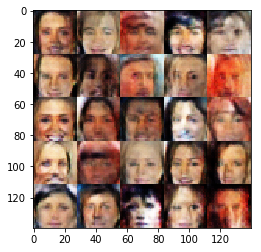

Epoch: 1/1 Discriminator Loss: 1.1338 Generator Loss: 1.3531
Epoch: 1/1 Discriminator Loss: 1.2553 Generator Loss: 0.9425
Epoch: 1/1 Discriminator Loss: 1.2065 Generator Loss: 1.4235
Epoch: 1/1 Discriminator Loss: 0.9862 Generator Loss: 1.0130
Epoch: 1/1 Discriminator Loss: 1.2388 Generator Loss: 1.0213
Epoch: 1/1 Discriminator Loss: 0.9709 Generator Loss: 1.8264
Epoch: 1/1 Discriminator Loss: 1.4589 Generator Loss: 1.2894
Epoch: 1/1 Discriminator Loss: 1.0134 Generator Loss: 1.6266
Epoch: 1/1 Discriminator Loss: 1.3224 Generator Loss: 0.5813
Epoch: 1/1 Discriminator Loss: 1.1226 Generator Loss: 1.0025


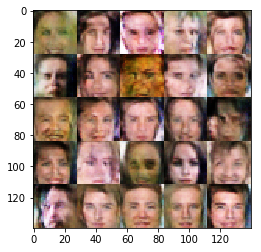

Epoch: 1/1 Discriminator Loss: 1.1567 Generator Loss: 0.8233
Epoch: 1/1 Discriminator Loss: 1.0939 Generator Loss: 1.1138
Epoch: 1/1 Discriminator Loss: 1.0572 Generator Loss: 1.1303
Epoch: 1/1 Discriminator Loss: 1.2487 Generator Loss: 0.7776
Epoch: 1/1 Discriminator Loss: 1.1885 Generator Loss: 1.4829
Epoch: 1/1 Discriminator Loss: 1.2749 Generator Loss: 1.0399
Epoch: 1/1 Discriminator Loss: 1.1355 Generator Loss: 0.7507
Epoch: 1/1 Discriminator Loss: 1.4990 Generator Loss: 1.5660
Epoch: 1/1 Discriminator Loss: 1.2890 Generator Loss: 0.6807
Epoch: 1/1 Discriminator Loss: 1.1614 Generator Loss: 1.2973


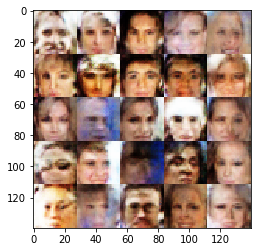

Epoch: 1/1 Discriminator Loss: 1.3287 Generator Loss: 0.7219
Epoch: 1/1 Discriminator Loss: 1.3146 Generator Loss: 0.6359
Epoch: 1/1 Discriminator Loss: 1.3034 Generator Loss: 0.8421
Epoch: 1/1 Discriminator Loss: 1.1065 Generator Loss: 0.8934
Epoch: 1/1 Discriminator Loss: 1.0392 Generator Loss: 1.3731
Epoch: 1/1 Discriminator Loss: 1.3649 Generator Loss: 0.5258
Epoch: 1/1 Discriminator Loss: 1.1095 Generator Loss: 1.1204
Epoch: 1/1 Discriminator Loss: 1.3162 Generator Loss: 1.5272
Epoch: 1/1 Discriminator Loss: 1.1740 Generator Loss: 1.0943
Epoch: 1/1 Discriminator Loss: 1.0675 Generator Loss: 1.3285


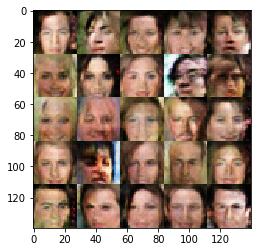

Epoch: 1/1 Discriminator Loss: 1.0497 Generator Loss: 0.9464
Epoch: 1/1 Discriminator Loss: 1.1960 Generator Loss: 0.9621
Epoch: 1/1 Discriminator Loss: 1.2463 Generator Loss: 0.8213
Epoch: 1/1 Discriminator Loss: 1.1211 Generator Loss: 1.0571
Epoch: 1/1 Discriminator Loss: 1.1043 Generator Loss: 1.1032
Epoch: 1/1 Discriminator Loss: 1.2390 Generator Loss: 0.6493
Epoch: 1/1 Discriminator Loss: 1.1425 Generator Loss: 0.8287
Epoch: 1/1 Discriminator Loss: 0.9240 Generator Loss: 1.3073
Epoch: 1/1 Discriminator Loss: 1.0664 Generator Loss: 1.9386
Epoch: 1/1 Discriminator Loss: 1.0884 Generator Loss: 1.1091


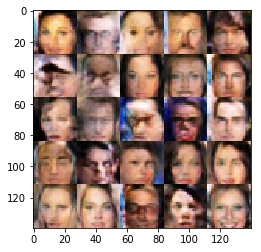

Epoch: 1/1 Discriminator Loss: 1.1081 Generator Loss: 1.5852
Epoch: 1/1 Discriminator Loss: 1.1950 Generator Loss: 1.5293
Epoch: 1/1 Discriminator Loss: 1.3382 Generator Loss: 0.7214
Epoch: 1/1 Discriminator Loss: 1.2074 Generator Loss: 0.9186
Epoch: 1/1 Discriminator Loss: 1.0508 Generator Loss: 1.2712
Epoch: 1/1 Discriminator Loss: 1.0257 Generator Loss: 1.2000
Epoch: 1/1 Discriminator Loss: 1.0805 Generator Loss: 1.0790
Epoch: 1/1 Discriminator Loss: 0.8558 Generator Loss: 1.5431
Epoch: 1/1 Discriminator Loss: 1.1716 Generator Loss: 0.9356
Epoch: 1/1 Discriminator Loss: 1.2845 Generator Loss: 0.9345


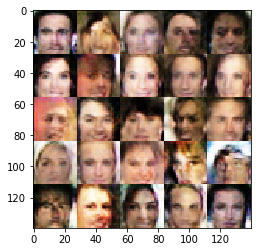

Epoch: 1/1 Discriminator Loss: 1.1411 Generator Loss: 0.8318
Epoch: 1/1 Discriminator Loss: 1.3386 Generator Loss: 2.0109
Epoch: 1/1 Discriminator Loss: 1.3270 Generator Loss: 1.2386
Epoch: 1/1 Discriminator Loss: 1.3863 Generator Loss: 0.7309
Epoch: 1/1 Discriminator Loss: 1.1287 Generator Loss: 0.8587
Epoch: 1/1 Discriminator Loss: 1.1666 Generator Loss: 1.5872
Epoch: 1/1 Discriminator Loss: 1.1999 Generator Loss: 0.8507
Epoch: 1/1 Discriminator Loss: 1.0440 Generator Loss: 1.2261
Epoch: 1/1 Discriminator Loss: 1.2041 Generator Loss: 1.0094
Epoch: 1/1 Discriminator Loss: 1.3992 Generator Loss: 0.8318


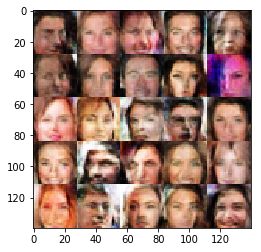

Epoch: 1/1 Discriminator Loss: 1.3153 Generator Loss: 1.9352
Epoch: 1/1 Discriminator Loss: 1.1678 Generator Loss: 0.8655
Epoch: 1/1 Discriminator Loss: 1.4832 Generator Loss: 0.4599
Epoch: 1/1 Discriminator Loss: 1.0128 Generator Loss: 1.0380
Epoch: 1/1 Discriminator Loss: 1.1908 Generator Loss: 1.8479
Epoch: 1/1 Discriminator Loss: 1.1949 Generator Loss: 1.6042
Epoch: 1/1 Discriminator Loss: 1.4159 Generator Loss: 0.8257
Epoch: 1/1 Discriminator Loss: 1.1029 Generator Loss: 1.1041
Epoch: 1/1 Discriminator Loss: 1.4863 Generator Loss: 0.9153
Epoch: 1/1 Discriminator Loss: 1.0060 Generator Loss: 1.2448


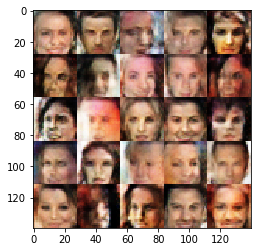

Epoch: 1/1 Discriminator Loss: 1.2311 Generator Loss: 1.0828
Epoch: 1/1 Discriminator Loss: 1.1625 Generator Loss: 1.1295
Epoch: 1/1 Discriminator Loss: 1.2923 Generator Loss: 0.6725
Epoch: 1/1 Discriminator Loss: 1.5228 Generator Loss: 0.4628
Epoch: 1/1 Discriminator Loss: 1.3658 Generator Loss: 0.7033
Epoch: 1/1 Discriminator Loss: 1.1848 Generator Loss: 0.9944
Epoch: 1/1 Discriminator Loss: 0.9557 Generator Loss: 1.2687
Epoch: 1/1 Discriminator Loss: 1.0980 Generator Loss: 1.3166
Epoch: 1/1 Discriminator Loss: 1.3048 Generator Loss: 1.0028
Epoch: 1/1 Discriminator Loss: 0.9581 Generator Loss: 1.0579


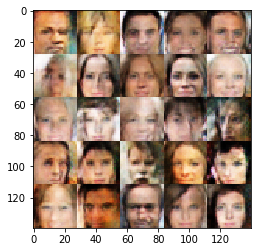

Epoch: 1/1 Discriminator Loss: 1.1493 Generator Loss: 0.9807
Epoch: 1/1 Discriminator Loss: 1.0104 Generator Loss: 1.1726
Epoch: 1/1 Discriminator Loss: 1.3130 Generator Loss: 1.6082
Epoch: 1/1 Discriminator Loss: 1.2659 Generator Loss: 0.8519
Epoch: 1/1 Discriminator Loss: 1.2305 Generator Loss: 1.4943
Epoch: 1/1 Discriminator Loss: 1.2221 Generator Loss: 1.0700
Epoch: 1/1 Discriminator Loss: 1.2523 Generator Loss: 1.2191
Epoch: 1/1 Discriminator Loss: 1.2978 Generator Loss: 0.6160
Epoch: 1/1 Discriminator Loss: 1.2325 Generator Loss: 0.8719
Epoch: 1/1 Discriminator Loss: 0.9487 Generator Loss: 1.4012


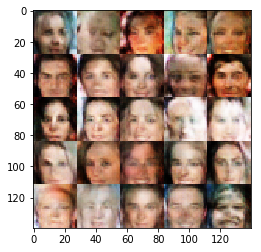

Epoch: 1/1 Discriminator Loss: 1.0119 Generator Loss: 0.9732
Epoch: 1/1 Discriminator Loss: 1.2540 Generator Loss: 1.0646
Epoch: 1/1 Discriminator Loss: 1.2772 Generator Loss: 1.1578
Epoch: 1/1 Discriminator Loss: 1.0553 Generator Loss: 1.2309
Epoch: 1/1 Discriminator Loss: 1.3845 Generator Loss: 0.7496
Epoch: 1/1 Discriminator Loss: 1.1683 Generator Loss: 1.1961
Epoch: 1/1 Discriminator Loss: 1.0964 Generator Loss: 1.2151
Epoch: 1/1 Discriminator Loss: 1.0543 Generator Loss: 1.3096
Epoch: 1/1 Discriminator Loss: 1.1469 Generator Loss: 1.1373
Epoch: 1/1 Discriminator Loss: 1.1884 Generator Loss: 0.9449


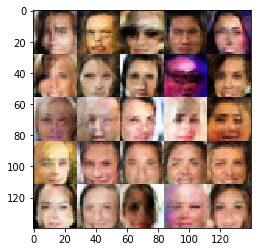

Epoch: 1/1 Discriminator Loss: 1.2224 Generator Loss: 1.2372
Epoch: 1/1 Discriminator Loss: 1.4449 Generator Loss: 1.0205
Epoch: 1/1 Discriminator Loss: 1.3848 Generator Loss: 1.0504
Epoch: 1/1 Discriminator Loss: 0.9941 Generator Loss: 1.1039
Epoch: 1/1 Discriminator Loss: 1.0398 Generator Loss: 1.2248
Epoch: 1/1 Discriminator Loss: 0.8530 Generator Loss: 0.9793
Epoch: 1/1 Discriminator Loss: 0.9056 Generator Loss: 1.8686
Epoch: 1/1 Discriminator Loss: 1.2426 Generator Loss: 1.0024
Epoch: 1/1 Discriminator Loss: 1.1037 Generator Loss: 0.8469
Epoch: 1/1 Discriminator Loss: 1.3913 Generator Loss: 0.6330


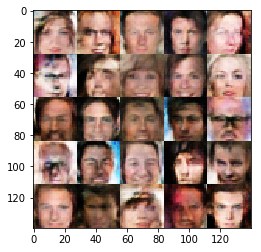

Epoch: 1/1 Discriminator Loss: 1.0938 Generator Loss: 1.1125
Epoch: 1/1 Discriminator Loss: 1.1568 Generator Loss: 1.3593
Epoch: 1/1 Discriminator Loss: 1.4855 Generator Loss: 0.5624
Epoch: 1/1 Discriminator Loss: 1.0794 Generator Loss: 0.9457
Epoch: 1/1 Discriminator Loss: 1.1602 Generator Loss: 0.8695
Epoch: 1/1 Discriminator Loss: 1.3190 Generator Loss: 0.6330
Epoch: 1/1 Discriminator Loss: 1.0640 Generator Loss: 1.0153
Epoch: 1/1 Discriminator Loss: 0.9822 Generator Loss: 1.3357
Epoch: 1/1 Discriminator Loss: 1.1287 Generator Loss: 1.1588
Epoch: 1/1 Discriminator Loss: 1.2004 Generator Loss: 0.7954


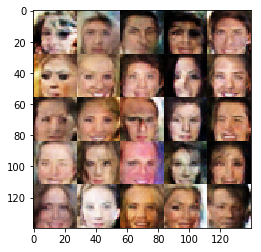

Epoch: 1/1 Discriminator Loss: 1.1511 Generator Loss: 1.1540
Epoch: 1/1 Discriminator Loss: 1.0015 Generator Loss: 0.9008
Epoch: 1/1 Discriminator Loss: 1.1736 Generator Loss: 0.8325
Epoch: 1/1 Discriminator Loss: 1.2123 Generator Loss: 1.3033
Epoch: 1/1 Discriminator Loss: 1.1020 Generator Loss: 1.4323
Epoch: 1/1 Discriminator Loss: 1.2023 Generator Loss: 1.0219
Epoch: 1/1 Discriminator Loss: 1.2338 Generator Loss: 0.9619
Epoch: 1/1 Discriminator Loss: 1.2541 Generator Loss: 0.8674
Epoch: 1/1 Discriminator Loss: 1.2959 Generator Loss: 1.8495
Epoch: 1/1 Discriminator Loss: 0.9739 Generator Loss: 1.3688


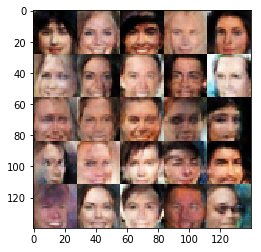

Epoch: 1/1 Discriminator Loss: 1.1521 Generator Loss: 1.9355
Epoch: 1/1 Discriminator Loss: 0.9512 Generator Loss: 1.3356
Epoch: 1/1 Discriminator Loss: 1.0077 Generator Loss: 1.0781
Epoch: 1/1 Discriminator Loss: 1.0847 Generator Loss: 1.0317
Epoch: 1/1 Discriminator Loss: 1.3742 Generator Loss: 1.0194
Epoch: 1/1 Discriminator Loss: 1.1123 Generator Loss: 1.4264
Epoch: 1/1 Discriminator Loss: 1.1733 Generator Loss: 1.0583
Epoch: 1/1 Discriminator Loss: 1.1173 Generator Loss: 1.0251
Epoch: 1/1 Discriminator Loss: 1.2619 Generator Loss: 0.8952
Epoch: 1/1 Discriminator Loss: 1.1531 Generator Loss: 0.8786


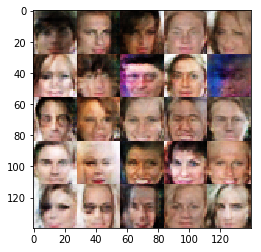

Epoch: 1/1 Discriminator Loss: 1.2198 Generator Loss: 0.9888
Epoch: 1/1 Discriminator Loss: 0.9914 Generator Loss: 1.2707
Epoch: 1/1 Discriminator Loss: 1.0894 Generator Loss: 0.8363
Epoch: 1/1 Discriminator Loss: 1.2410 Generator Loss: 1.0229
Epoch: 1/1 Discriminator Loss: 1.3196 Generator Loss: 0.7988
Epoch: 1/1 Discriminator Loss: 1.1356 Generator Loss: 1.2319
Epoch: 1/1 Discriminator Loss: 1.1203 Generator Loss: 1.4674
Epoch: 1/1 Discriminator Loss: 1.3766 Generator Loss: 0.7029
Epoch: 1/1 Discriminator Loss: 1.1147 Generator Loss: 1.0370
Epoch: 1/1 Discriminator Loss: 1.1976 Generator Loss: 0.9463


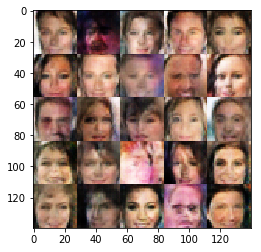

Epoch: 1/1 Discriminator Loss: 1.0048 Generator Loss: 1.0098
Epoch: 1/1 Discriminator Loss: 1.2173 Generator Loss: 0.9942
Epoch: 1/1 Discriminator Loss: 1.0741 Generator Loss: 1.2823
Epoch: 1/1 Discriminator Loss: 1.1123 Generator Loss: 0.8901
Epoch: 1/1 Discriminator Loss: 1.1029 Generator Loss: 0.9651
Epoch: 1/1 Discriminator Loss: 0.9609 Generator Loss: 1.0882
Epoch: 1/1 Discriminator Loss: 1.2161 Generator Loss: 0.6198
Epoch: 1/1 Discriminator Loss: 1.3318 Generator Loss: 0.8754
Epoch: 1/1 Discriminator Loss: 1.1231 Generator Loss: 1.1338
Epoch: 1/1 Discriminator Loss: 1.1521 Generator Loss: 0.8435


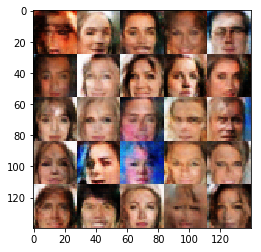

Epoch: 1/1 Discriminator Loss: 1.3056 Generator Loss: 0.6065
Epoch: 1/1 Discriminator Loss: 1.0406 Generator Loss: 1.2964
Epoch: 1/1 Discriminator Loss: 1.1071 Generator Loss: 1.1785
Epoch: 1/1 Discriminator Loss: 1.0479 Generator Loss: 1.3238
Epoch: 1/1 Discriminator Loss: 1.1308 Generator Loss: 1.0664
Epoch: 1/1 Discriminator Loss: 1.1023 Generator Loss: 1.5657
Epoch: 1/1 Discriminator Loss: 1.1341 Generator Loss: 1.2460
Epoch: 1/1 Discriminator Loss: 1.0216 Generator Loss: 1.1099
Epoch: 1/1 Discriminator Loss: 1.0693 Generator Loss: 0.9704
Epoch: 1/1 Discriminator Loss: 1.2473 Generator Loss: 0.8837


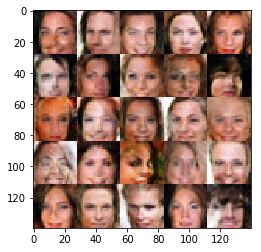

Epoch: 1/1 Discriminator Loss: 1.0941 Generator Loss: 1.6594
Epoch: 1/1 Discriminator Loss: 1.2463 Generator Loss: 1.5945
Epoch: 1/1 Discriminator Loss: 1.2680 Generator Loss: 1.2339


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。